In [3]:
#Import Libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [4]:
#Load All Data

sales = pd.read_csv("data/Online_Sales.csv")
customers = pd.read_excel("data/CustomersData.xlsx")
coupons = pd.read_csv("data/Discount_Coupon.csv")
marketing = pd.read_csv("data/Marketing_Spend.csv")
tax = pd.read_excel("data/Tax_amount.xlsx")

In [5]:

#Initial Exploration
sales.info()
sales.head()

customers.info()
coupons.info()
marketing.info()
tax.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52924 non-null  int64  
 1   Transaction_ID       52924 non-null  int64  
 2   Transaction_Date     52924 non-null  object 
 3   Product_SKU          52924 non-null  object 
 4   Product_Description  52924 non-null  object 
 5   Product_Category     52924 non-null  object 
 6   Quantity             52924 non-null  int64  
 7   Avg_Price            52924 non-null  float64
 8   Delivery_Charges     52924 non-null  float64
 9   Coupon_Status        52924 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 4.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1468 non-null   i

In [6]:
# Missing values
sales.isnull().sum()

# Duplicates
sales.duplicated().sum()


np.int64(0)

In [7]:
sales.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used


C:\Users\Harsha vardhan\AppData\Local\Temp\ipykernel_25792\615291555.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Acquisition_Month', y='New_Customers_counts', data=Count_acquisition, palette='Blues_d')


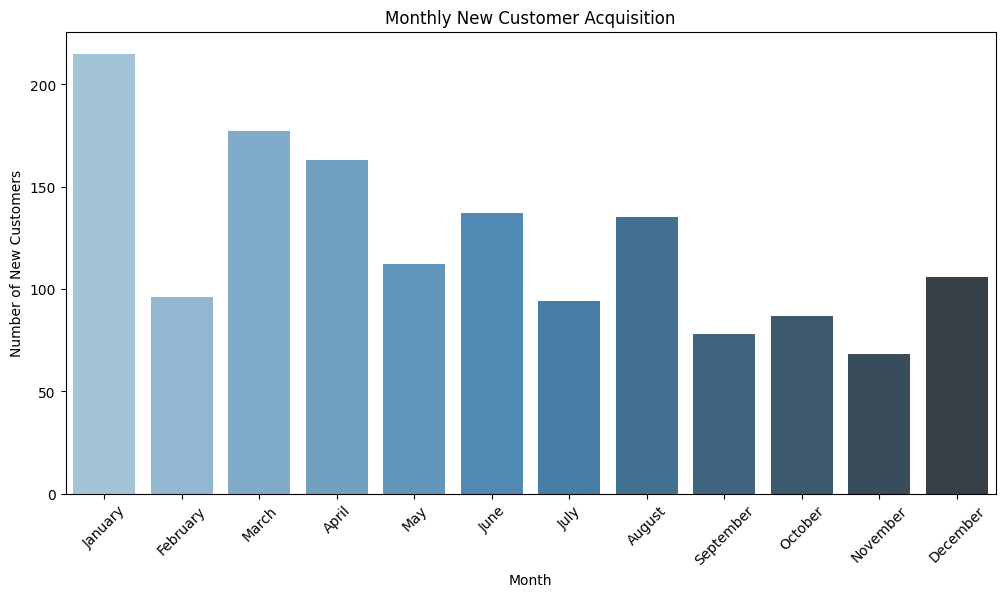

In [8]:
#Business Question 1:


# Step 1: Prepare the Data for Acquisition Analysis
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])
sales['Transaction_Month_Name'] = sales['Transaction_Date'].dt.month_name()
first_purchase = sales.groupby('CustomerID')['Transaction_Date'].min().reset_index()
first_purchase['Acquisition_Month'] = first_purchase['Transaction_Date'].dt.month_name()

# Count new customers by month
Count_acquisition = first_purchase['Acquisition_Month'].value_counts().reset_index()
Count_acquisition.columns = ['Acquisition_Month', 'New_Customers_counts']

# Correct Month Order using Categorical
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
Count_acquisition['Acquisition_Month'] = pd.Categorical(Count_acquisition['Acquisition_Month'], 
                                                        categories=month_order, ordered=True)

# Sort properly
Count_acquisition = Count_acquisition.sort_values('Acquisition_Month')

# Step 2: Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Acquisition_Month', y='New_Customers_counts', data=Count_acquisition, palette='Blues_d')
plt.title('Monthly New Customer Acquisition')
plt.xlabel('Month')
plt.ylabel('Number of New Customers')
plt.xticks(rotation=45)
plt.show()


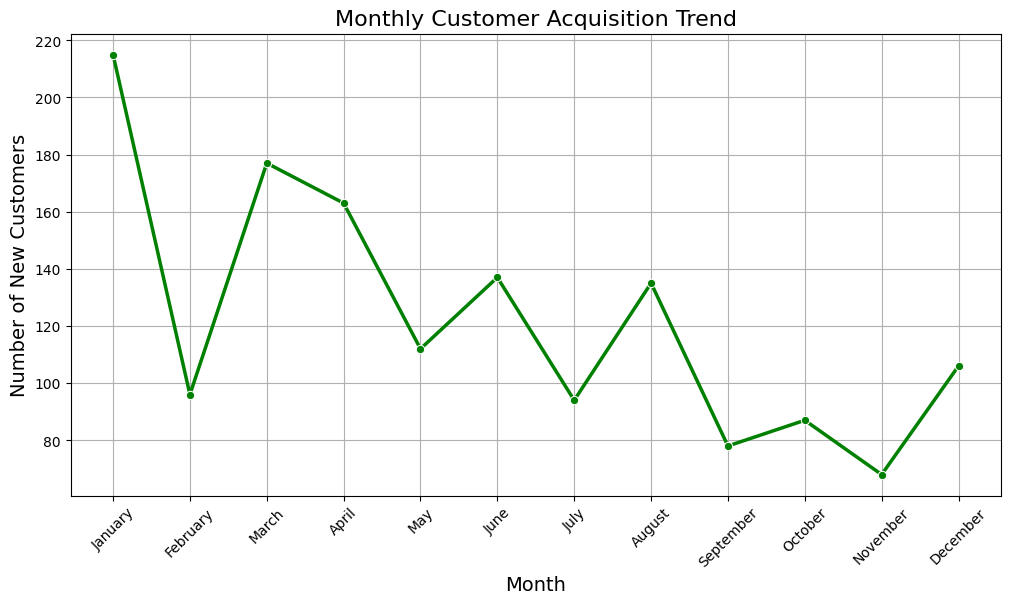

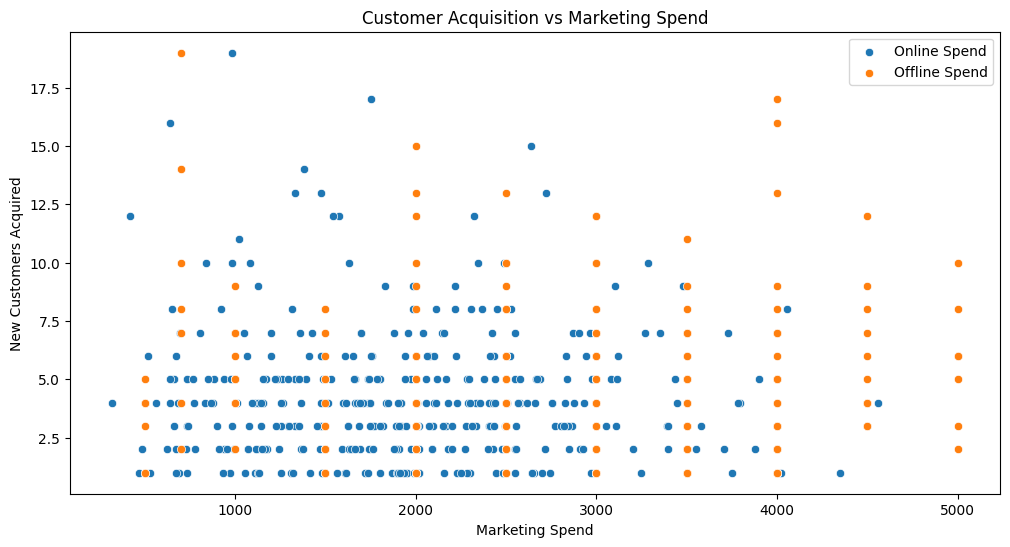

               Online_Spend  Offline_Spend  New_Customers
Online_Spend       1.000000       0.359650      -0.033492
Offline_Spend      0.359650       1.000000      -0.024382
New_Customers     -0.033492      -0.024382       1.000000


In [9]:
#Business Question 2 : 


plt.figure(figsize=(12,6))
sns.lineplot(x='Acquisition_Month', y='New_Customers_counts', 
             data=Count_acquisition, marker='o', linewidth=2.5, color='green')

plt.title("Monthly Customer Acquisition Trend", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of New Customers", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


#Analyze whether higher marketing spend (online/offline) correlates with more new customers acquired on those days.

marketing['Date'] = pd.to_datetime(marketing['Date'])
daily_acquisition = first_purchase.groupby('Transaction_Date').size().reset_index(name='New_Customers')
# Merge on date
merged = pd.merge(daily_acquisition, marketing, left_on='Transaction_Date', right_on='Date')

# Drop duplicate date column if needed
merged.drop(columns=['Date'], inplace=True)
plt.figure(figsize=(12,6))
sns.scatterplot(data=merged, x='Online_Spend', y='New_Customers', label='Online Spend')
sns.scatterplot(data=merged, x='Offline_Spend', y='New_Customers', label='Offline Spend')
plt.title("Customer Acquisition vs Marketing Spend")
plt.xlabel("Marketing Spend")
plt.ylabel("New Customers Acquired")
plt.legend()
plt.show()
print(merged[['Online_Spend', 'Offline_Spend', 'New_Customers']].corr())



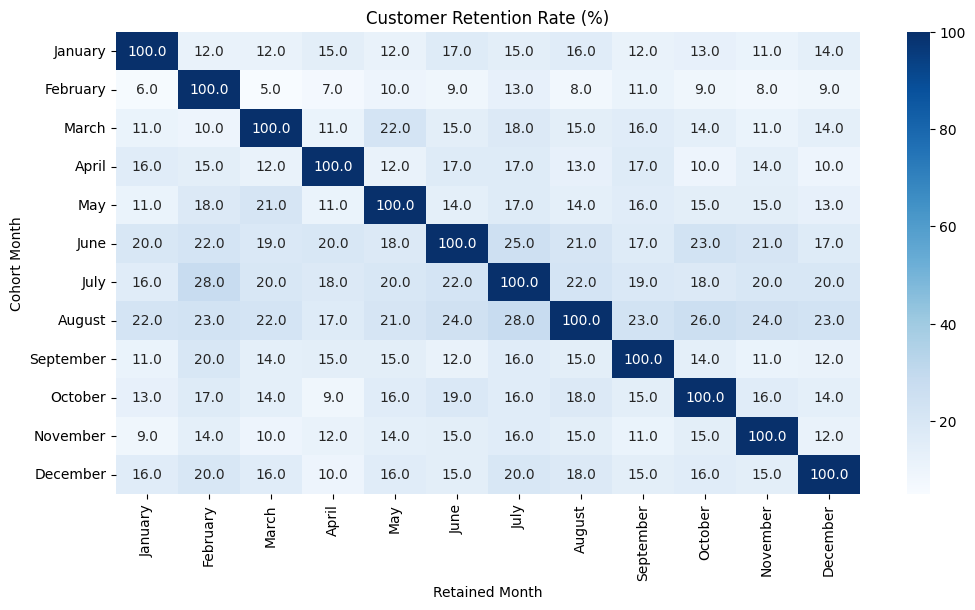

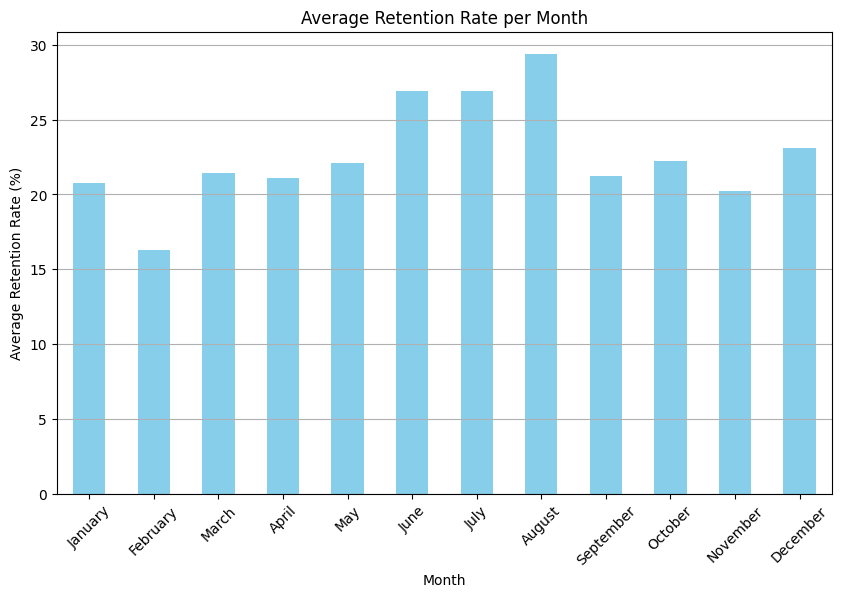

In [10]:
#Business Question 3 :

#Identify periods with the strongest and weakest retention rates.
# What strategies could be implemented to improve retention during weaker months?

sales['Transaction_Month'] = sales['Transaction_Date'].dt.to_period('M')

# Get distinct customers per month
monthly_customers = sales.groupby('Transaction_Month')['CustomerID'].nunique().reset_index(name='Unique_Customers')
monthly_customers.head()


customer_month = sales.pivot_table(index='CustomerID',
                                   columns='Transaction_Month',
                                   values='Transaction_ID',
                                   aggfunc='count').fillna(0)

customer_month = customer_month.map(lambda x: 1 if x > 0 else 0)

retention_counts = customer_month.sum(axis=0)

# I am unable to find the approach and tried my best so , Finally got this from chatgpt. Just the below line thats it.
retention_matrix = customer_month.T.dot(customer_month)
retention_rate = retention_matrix.divide(retention_counts, axis=1).round(2) * 100

# Convert Period to Month Names for both axis
retention_rate.index = retention_rate.index.strftime('%B')
retention_rate.columns = retention_rate.columns.strftime('%B')

# Calculate average retention after acquisition month
avg_retention_per_month = retention_rate.mean(axis=1)




plt.figure(figsize=(12, 6))
sns.heatmap(retention_rate, annot=True, fmt=".1f", cmap="Blues", cbar=True)
plt.title('Customer Retention Rate (%)')
plt.xlabel('Retained Month')
plt.ylabel('Cohort Month')
plt.show()


# Plot
plt.figure(figsize=(10, 6))
avg_retention_per_month.plot(kind='bar', color='skyblue')
plt.title('Average Retention Rate per Month')
plt.ylabel('Average Retention Rate (%)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

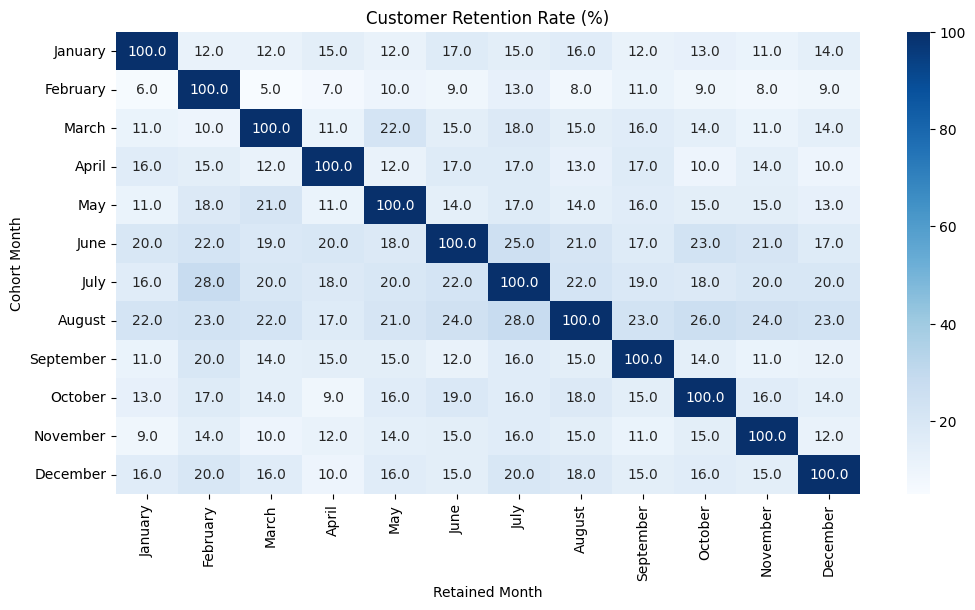

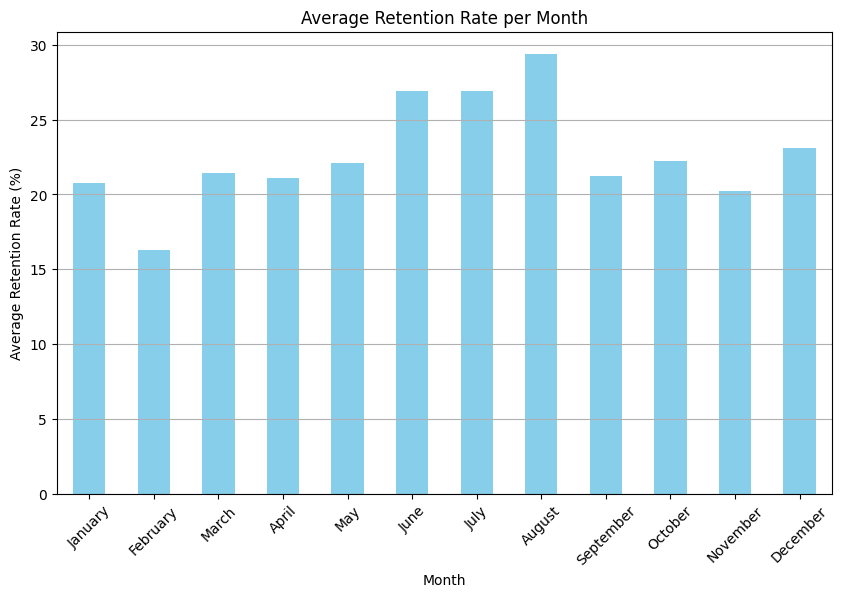

In [11]:
#Business Question 3 :

#Identify periods with the strongest and weakest retention rates.
# What strategies could be implemented to improve retention during weaker months?

sales['Transaction_Month'] = sales['Transaction_Date'].dt.to_period('M')

# Get distinct customers per month
monthly_customers = sales.groupby('Transaction_Month')['CustomerID'].nunique().reset_index(name='Unique_Customers')
monthly_customers.head()


customer_month = sales.pivot_table(index='CustomerID',
                                   columns='Transaction_Month',
                                   values='Transaction_ID',
                                   aggfunc='count').fillna(0)

customer_month = customer_month.map(lambda x: 1 if x > 0 else 0)

retention_counts = customer_month.sum(axis=0)

# I am unable to find the approach and tried my best so , Finally got this from chatgpt. Just the below line thats it.
retention_matrix = customer_month.T.dot(customer_month)
retention_rate = retention_matrix.divide(retention_counts, axis=1).round(2) * 100

# Convert Period to Month Names for both axis
retention_rate.index = retention_rate.index.strftime('%B')
retention_rate.columns = retention_rate.columns.strftime('%B')

# Calculate average retention after acquisition month
avg_retention_per_month = retention_rate.mean(axis=1)




plt.figure(figsize=(12, 6))
sns.heatmap(retention_rate, annot=True, fmt=".1f", cmap="Blues", cbar=True)
plt.title('Customer Retention Rate (%)')
plt.xlabel('Retained Month')
plt.ylabel('Cohort Month')
plt.show()


# Plot
plt.figure(figsize=(10, 6))
avg_retention_per_month.plot(kind='bar', color='skyblue')
plt.title('Average Retention Rate per Month')
plt.ylabel('Average Retention Rate (%)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


C:\Users\Harsha vardhan\AppData\Local\Temp\ipykernel_25792\3431046423.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_order_value = sales.groupby('Transaction_Month_Name').apply(


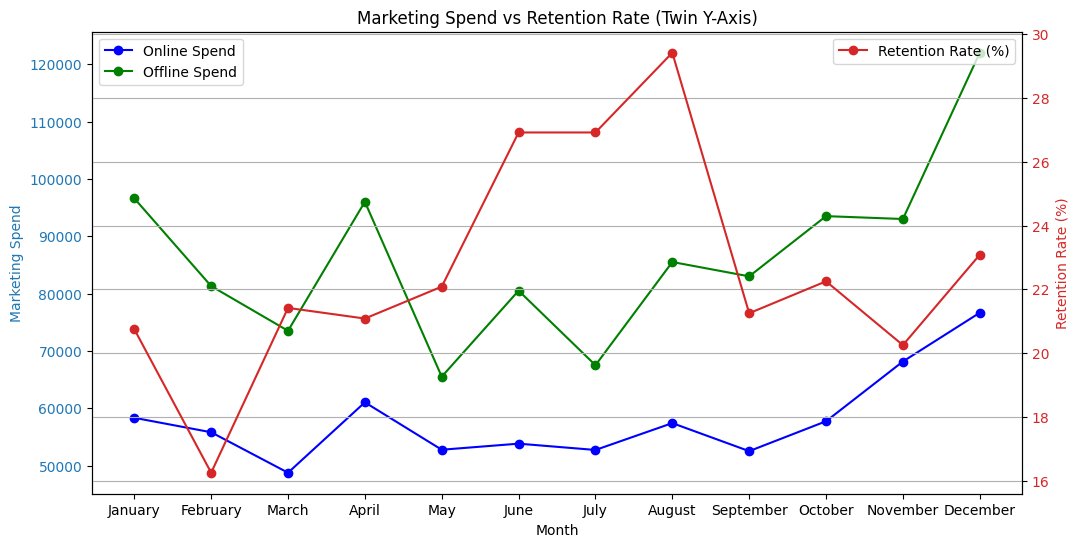

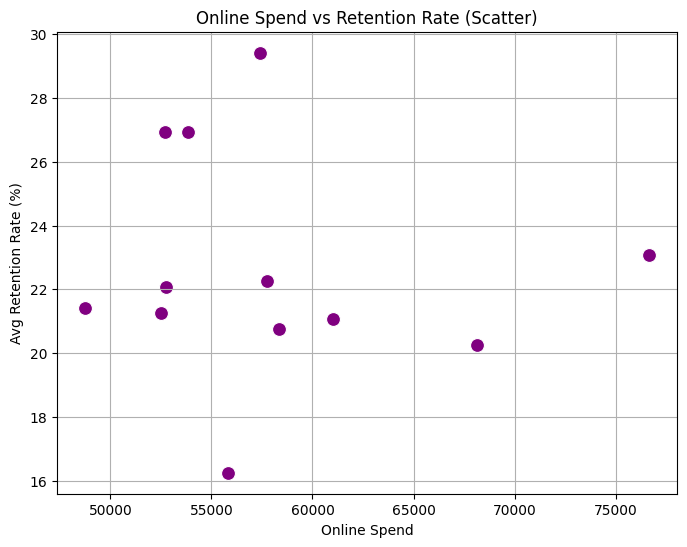

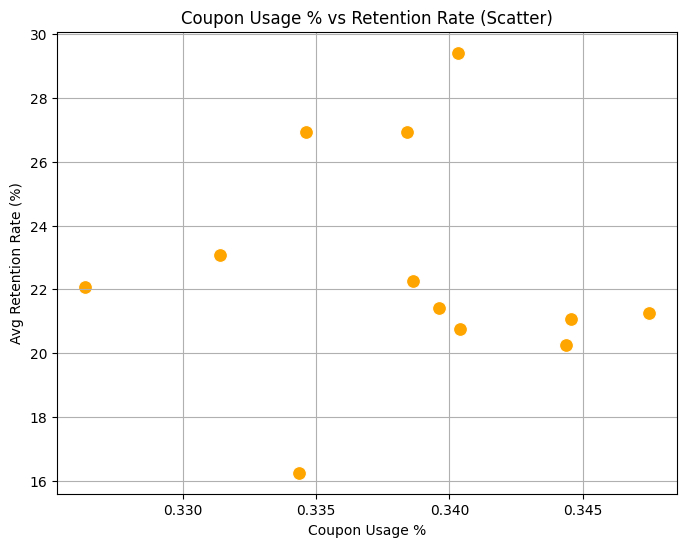

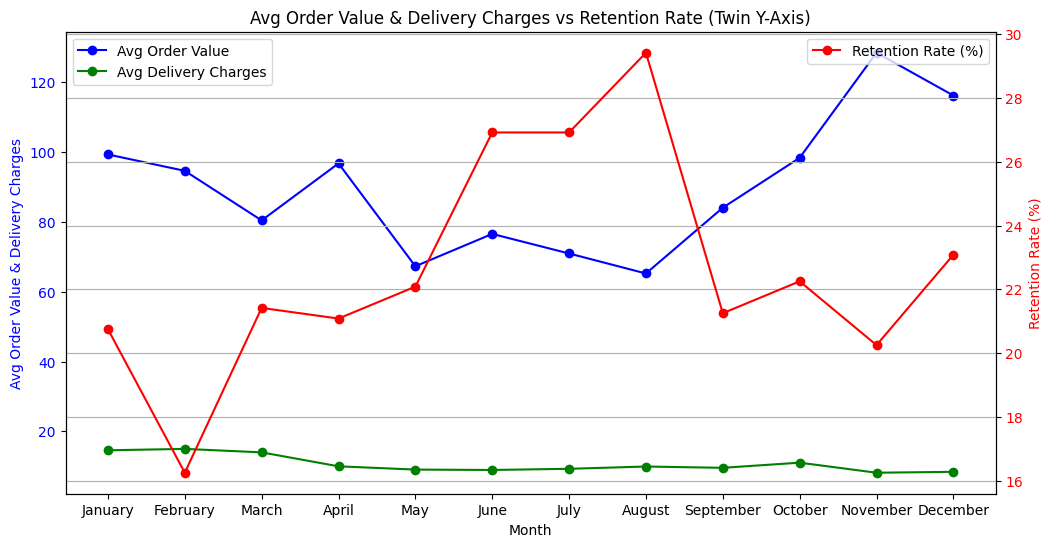

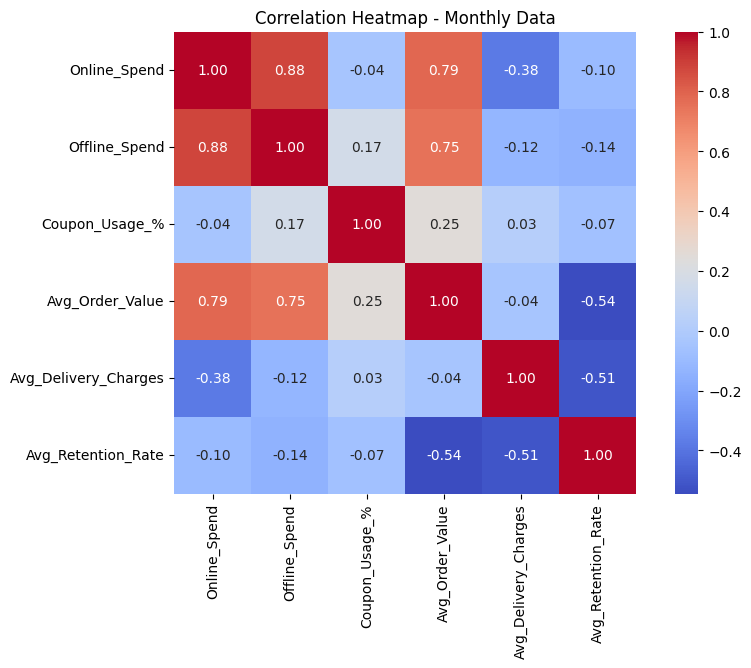

In [12]:
#Business Question 4 :

#Analyze customer behavior during high-retention months and suggest ways to replicate this success throughout the year.


# PHASE 1: Clean Consolidated Monthly Dataset


# Average Order Value per Month
monthly_order_value = sales.groupby('Transaction_Month_Name').apply(
    lambda x: (x['Quantity'] * x['Avg_Price']).sum() / len(x)
).reset_index(name='Avg_Order_Value')

# Average Delivery Charges per Month
monthly_delivery_charges = sales.groupby('Transaction_Month_Name')['Delivery_Charges'].mean().reset_index(name='Avg_Delivery_Charges')

# Coupon Usage % per Month (from sales data)
monthly_coupon_usage = sales.groupby('Transaction_Month_Name')['Coupon_Status'].value_counts(normalize=True).rename('Coupon_Usage_%').reset_index()
monthly_coupon_used = monthly_coupon_usage[monthly_coupon_usage['Coupon_Status'] == 'Used'][['Transaction_Month_Name', 'Coupon_Usage_%']]

# Marketing Spend Aggregation (from your marketing data)
marketing['Date'] = pd.to_datetime(marketing['Date'])
marketing['Month'] = marketing['Date'].dt.month_name()
monthly_marketing_spend = marketing.groupby('Month')[['Online_Spend', 'Offline_Spend']].sum().reset_index()

# Clean Retention Rate (from your Q3 avg_retention_per_month already calculated)
avg_retention_per_month_df = avg_retention_per_month.reset_index()
avg_retention_per_month_df.columns = ['Month', 'Avg_Retention_Rate']

# Create the consolidated table
consolidated_monthly = monthly_marketing_spend.merge(
    monthly_order_value, left_on='Month', right_on='Transaction_Month_Name', how='left'
).merge(
    monthly_delivery_charges, left_on='Month', right_on='Transaction_Month_Name', how='left'
).merge(
    monthly_coupon_used, left_on='Month', right_on='Transaction_Month_Name', how='left'
).merge(
    avg_retention_per_month_df, on='Month', how='left'
)

# Clean columns
consolidated_monthly = consolidated_monthly[['Month', 'Online_Spend', 'Offline_Spend',
                                             'Avg_Order_Value', 'Avg_Delivery_Charges',
                                             'Coupon_Usage_%', 'Avg_Retention_Rate']]

# Ensure correct month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
consolidated_monthly['Month'] = pd.Categorical(consolidated_monthly['Month'], categories=month_order, ordered=True)
consolidated_monthly = consolidated_monthly.sort_values('Month')

# Preview the clean dataset
consolidated_monthly



# Phase 2: Real Plots and Correlation Matrix using consolidated_monthly

# Plot 1: Marketing Spend vs Retention Rate (with twin y-axis)
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Marketing Spend', color=color)
ax1.plot(consolidated_monthly['Month'], consolidated_monthly['Online_Spend'], marker='o', color='blue', label='Online Spend')
ax1.plot(consolidated_monthly['Month'], consolidated_monthly['Offline_Spend'], marker='o', color='green', label='Offline Spend')
ax1.tick_params(axis='y', labelcolor=color)

# Create secondary y-axis for Retention Rate
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Retention Rate (%)', color=color)
ax2.plot(consolidated_monthly['Month'], consolidated_monthly['Avg_Retention_Rate'], marker='o', color=color, label='Retention Rate (%)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Marketing Spend vs Retention Rate (Twin Y-Axis)')
plt.xticks(rotation=45)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot 2: Online Spend vs Retention Rate (scatter)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Online_Spend', y='Avg_Retention_Rate', data=consolidated_monthly, color='purple', s=100)
plt.title('Online Spend vs Retention Rate (Scatter)')
plt.xlabel('Online Spend')
plt.ylabel('Avg Retention Rate (%)')
plt.grid(True)
plt.show()

# Plot 3: Coupon Usage % vs Retention Rate (scatter)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Coupon_Usage_%', y='Avg_Retention_Rate', data=consolidated_monthly, color='orange', s=100)
plt.title('Coupon Usage % vs Retention Rate (Scatter)')
plt.xlabel('Coupon Usage %')
plt.ylabel('Avg Retention Rate (%)')
plt.grid(True)
plt.show()

# Plot 4: Avg Order Value & Delivery Charges vs Retention Rate (Twin Y-Axis)
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Month')
ax1.set_ylabel('Avg Order Value & Delivery Charges', color='blue')
ax1.plot(consolidated_monthly['Month'], consolidated_monthly['Avg_Order_Value'], marker='o', color='blue', label='Avg Order Value')
ax1.plot(consolidated_monthly['Month'], consolidated_monthly['Avg_Delivery_Charges'], marker='o', color='green', label='Avg Delivery Charges')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Retention Rate (%)', color='red')
ax2.plot(consolidated_monthly['Month'], consolidated_monthly['Avg_Retention_Rate'], marker='o', color='red', label='Retention Rate (%)')
ax2.tick_params(axis='y', labelcolor='red')


plt.title('Avg Order Value & Delivery Charges vs Retention Rate (Twin Y-Axis)')
plt.xticks(rotation=45)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot 5: Correlation Heatmap
plt.figure(figsize=(10, 6))
corr = consolidated_monthly[['Online_Spend', 'Offline_Spend', 'Coupon_Usage_%', 'Avg_Order_Value', 'Avg_Delivery_Charges', 'Avg_Retention_Rate']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap - Monthly Data')

plt.show()



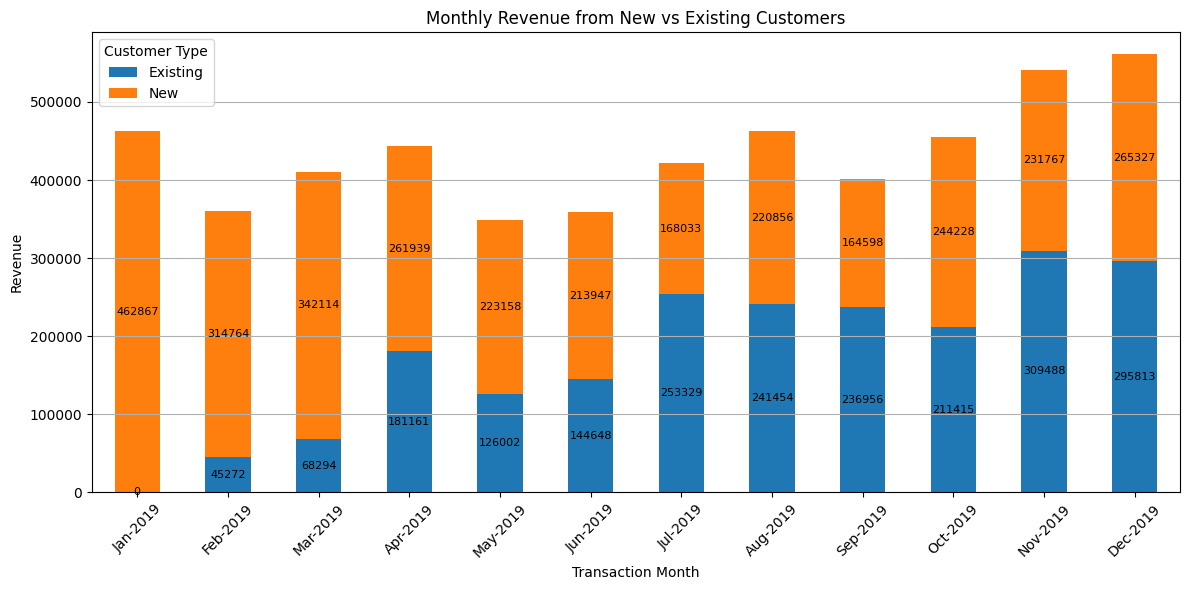

In [ ]:
#Business Question 5 :
#Compare the revenue generated by new and existing customers month-over-month.
#What does this trend suggest about the balance between acquisition and retention efforts?

first_purchase['First_Purchase_Month'] = pd.to_datetime(first_purchase['Transaction_Date']).dt.to_period('M')



sales['Transaction_Month'] = sales['Transaction_Date'].dt.to_period('M')


sales_labeled = sales.merge(first_purchase[['CustomerID', 'Transaction_Date']], on='CustomerID', how='left')

sales_labeled['First_Purchase_Month'] = pd.to_datetime(sales_labeled['Transaction_Date_y']).dt.to_period('M')


sales_labeled['Customer_Type'] = sales_labeled.apply(lambda x: 'New' if x['Transaction_Month'] == x['First_Purchase_Month'] else 'Existing', axis=1)


sales_labeled['Revenue'] = sales_labeled['Quantity'] * sales_labeled['Avg_Price'] + sales_labeled['Delivery_Charges']


monthly_revenue = sales_labeled.groupby(['Transaction_Month', 'Customer_Type'])['Revenue'].sum().reset_index()


pivot_revenue = monthly_revenue.pivot(index='Transaction_Month', columns='Customer_Type', values='Revenue').fillna(0)

plt.figure(figsize=(12, 6))
ax = pivot_revenue.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Monthly Revenue from New vs Existing Customers')
plt.ylabel('Revenue')
plt.xlabel('Transaction Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Customer Type')


for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='center', fontsize=8, color='black')
pivot_revenue.index = pivot_revenue.index.to_timestamp()
plt.xticks(ticks=np.arange(len(pivot_revenue.index)), labels=pivot_revenue.index.strftime('%b-%Y'), rotation=45)

plt.tight_layout()
plt.show()



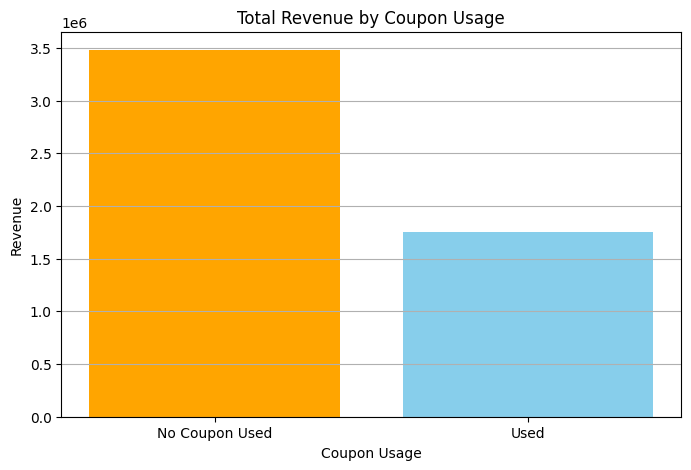

<Figure size 1200x600 with 0 Axes>

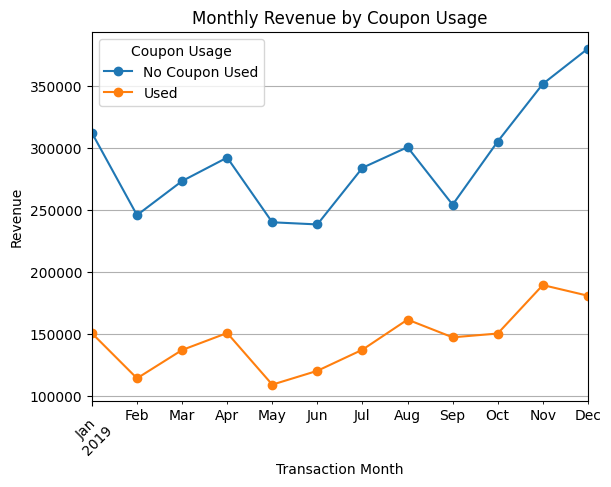

In [22]:
#Business Question 6 :
#Analyze the relationship between coupon usage and revenue generation.
#How can discount strategies be optimized to maximize revenue while maintaining profitability?

sales_q6 = sales.copy()


sales_q6['Revenue'] = sales_q6['Quantity'] * sales_q6['Avg_Price'] + sales_q6['Delivery_Charges']


sales_q6['Coupon_Status_Corrected'] = sales_q6['Coupon_Status'].replace({'Clicked': 'No Coupon Used', 'Not Used': 'No Coupon Used', 'Used': 'Used'})


corrected_coupon_revenue = sales_q6.groupby('Coupon_Status_Corrected')['Revenue'].sum().reset_index()


plt.figure(figsize=(8, 5))
plt.bar(corrected_coupon_revenue['Coupon_Status_Corrected'], corrected_coupon_revenue['Revenue'], color=['orange', 'skyblue'])
plt.title('Total Revenue by Coupon Usage')
plt.ylabel('Revenue')
plt.xlabel('Coupon Usage')
plt.grid(axis='y')
plt.show()


monthly_coupon_revenue_corrected = sales_q6.groupby(['Transaction_Month', 'Coupon_Status_Corrected'])['Revenue'].sum().reset_index()

pivot_monthly_corrected = monthly_coupon_revenue_corrected.pivot(index='Transaction_Month', columns='Coupon_Status_Corrected', values='Revenue').fillna(0)

plt.figure(figsize=(12, 6))
pivot_monthly_corrected.plot(kind='line', marker='o')
plt.title('Monthly Revenue by Coupon Usage')
plt.ylabel('Revenue')
plt.xlabel('Transaction Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Coupon Usage')

plt.show()


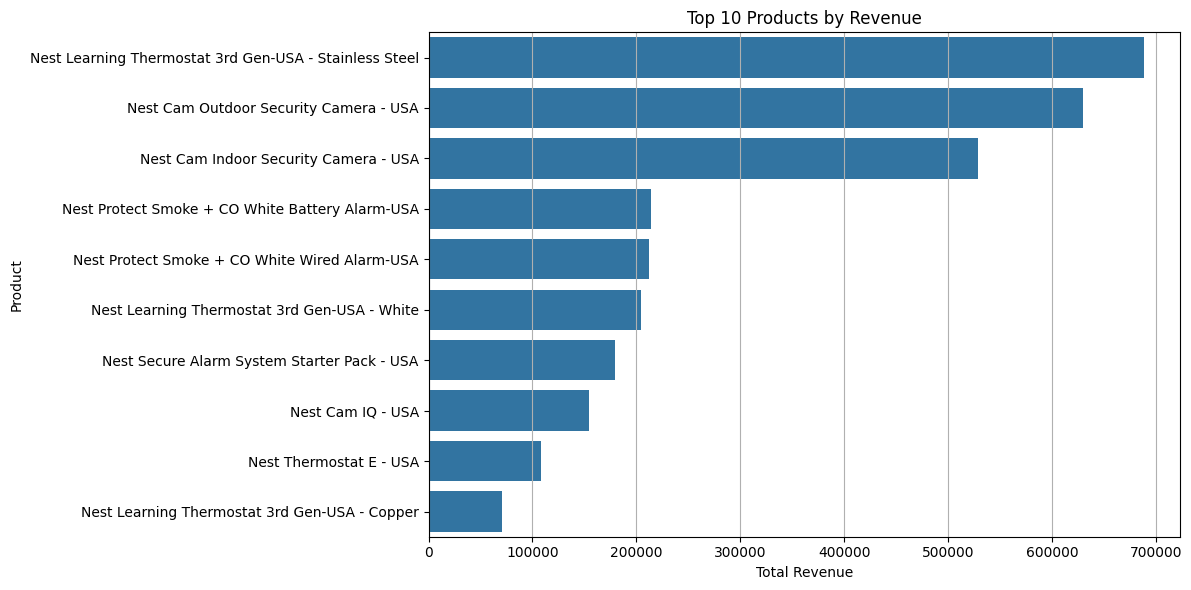

<Figure size 1000x600 with 0 Axes>

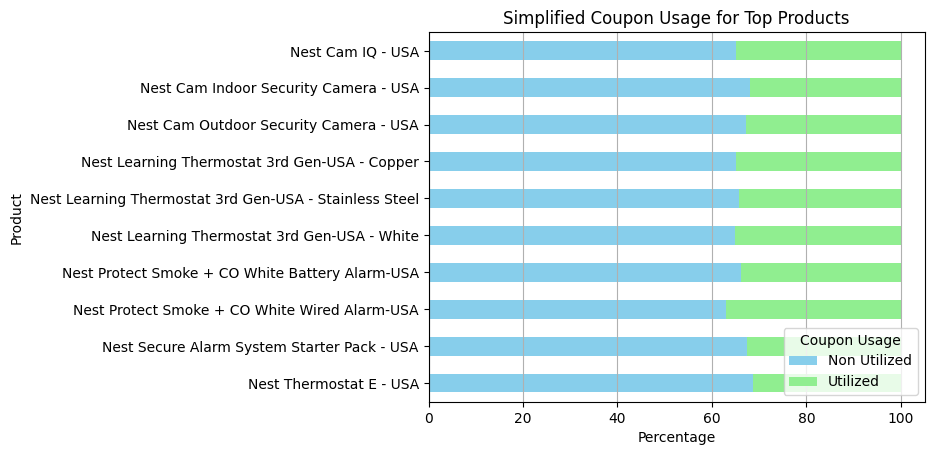

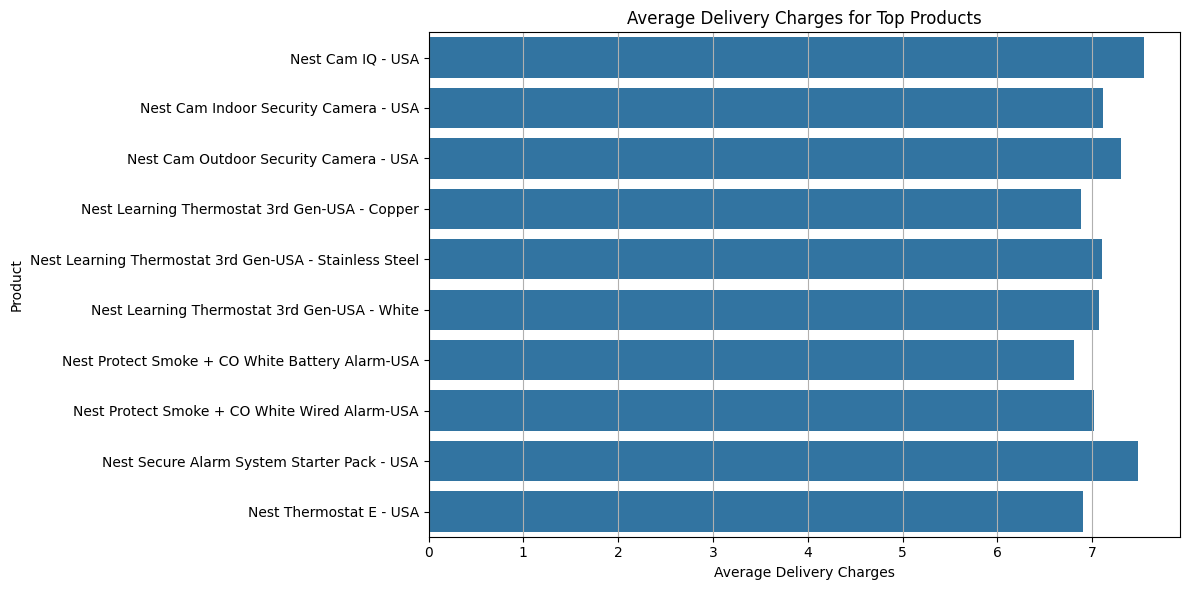

<Figure size 1200x600 with 0 Axes>

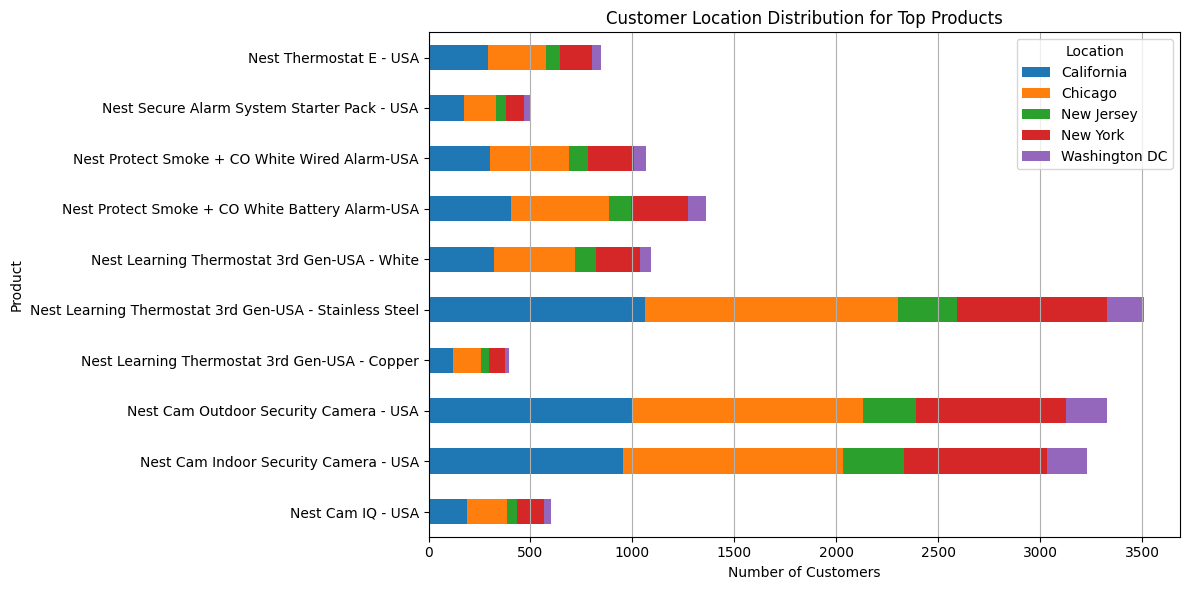

In [33]:
#Business Question 7 :
#Identify the top-performing products and analyze the factors driving their success. 
# How can this insight inform inventory management and promotional strategies?

sales['Revenue'] = sales['Quantity'] * sales['Avg_Price']
product_revenue = sales.groupby('Product_Description').agg(
    Total_Revenue=('Revenue', 'sum'),
    Total_Quantity=('Quantity', 'sum')
).sort_values(by='Total_Revenue', ascending=False).head(10).reset_index()

# Step 2: Analysis of key drivers for top products

# Filter for top products
top_products_list = product_revenue['Product_Description'].tolist()
top_sales = sales[sales['Product_Description'].isin(top_products_list)]

# Coupon usage analysis
coupon_usage = top_sales.groupby('Product_Description')['Coupon_Status'].value_counts(normalize=True).unstack().fillna(0) * 100
coupon_usage_simplified = pd.DataFrame()
coupon_usage_simplified['Non Utilized'] = coupon_usage.get('Clicked', 0) + coupon_usage.get('Not Used', 0)
coupon_usage_simplified['Utilized'] = coupon_usage.get('Used', 0)




# Delivery charges
delivery_avg = top_sales.groupby('Product_Description')['Delivery_Charges'].mean().reset_index()

# Customer demographics
top_sales_cust = top_sales.merge(customers, on='CustomerID', how='left')
location_distribution = top_sales_cust.groupby(['Product_Description', 'Location']).size().unstack().fillna(0)

# Plot 1: Top 10 Products by Revenue
plt.figure(figsize=(12, 6))
sns.barplot(x='Total_Revenue', y='Product_Description', data=product_revenue)
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product')
plt.grid(axis='x')
plt.tight_layout()
#plt.savefig("images/Q7_Top_10_Products_Revenue.png")
plt.show()

# Plot 2: Simplified Coupon Usage for Top Products
plt.figure(figsize=(10, 6))
coupon_usage_simplified.plot(kind='barh', stacked=True, color=['skyblue', 'lightgreen'])
plt.title('Simplified Coupon Usage for Top Products')
plt.xlabel('Percentage')
plt.ylabel('Product')
plt.legend(title='Coupon Usage', loc='lower right')
plt.grid(axis='x')
plt.gca().invert_yaxis()
#plt.savefig("images/Q7_Simplified_Coupon_Usage.png")
plt.show()

# Plot 3: Average Delivery Charges for Top Products
plt.figure(figsize=(12, 6))
sns.barplot(x='Delivery_Charges', y='Product_Description', data=delivery_avg)
plt.title('Average Delivery Charges for Top Products')
plt.xlabel('Average Delivery Charges')
plt.ylabel('Product')
plt.grid(axis='x')
plt.tight_layout()
#plt.savefig("images/Q7_Average_Delivery_Charges.png")
plt.show()

# Plot 4: Customer Location Distribution for Top Products
plt.figure(figsize=(12, 6))
location_distribution.plot(kind='barh', stacked=True, figsize=(12, 6))
plt.title('Customer Location Distribution for Top Products')
plt.xlabel('Number of Customers')
plt.ylabel('Product')
plt.legend(title='Location')
plt.grid(axis='x')
plt.tight_layout()
#plt.savefig("images/Q7_Customer_Location_Distribution.png")
plt.show()


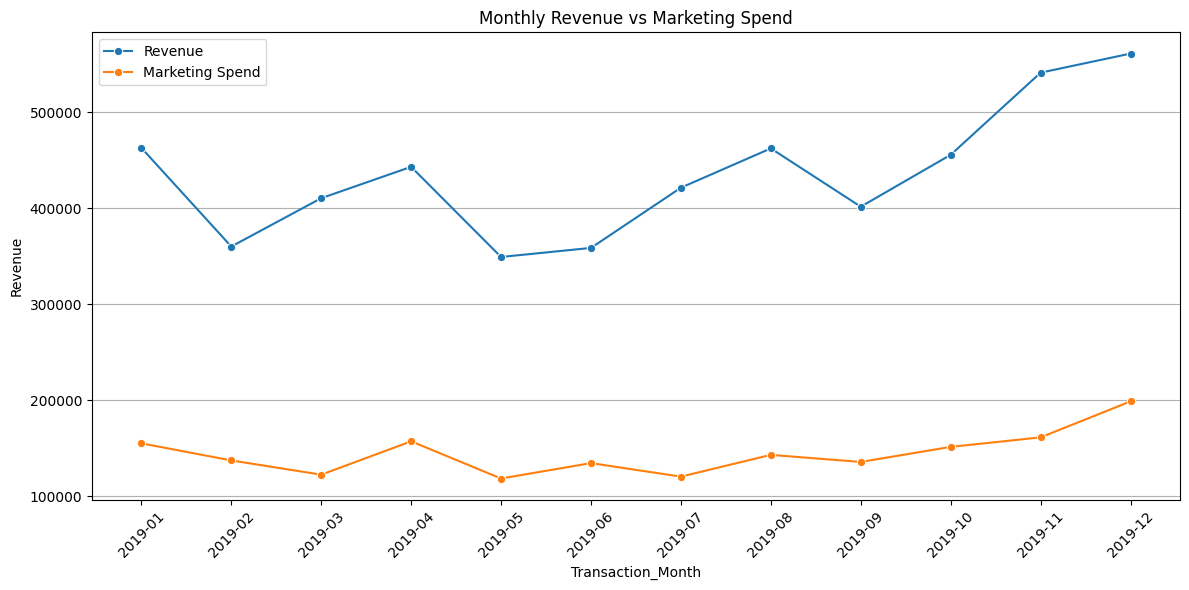

C:\Users\Harsha vardhan\AppData\Local\Temp\ipykernel_25792\4090794484.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Transaction_Month', y='ROI', data=combined, palette='coolwarm')


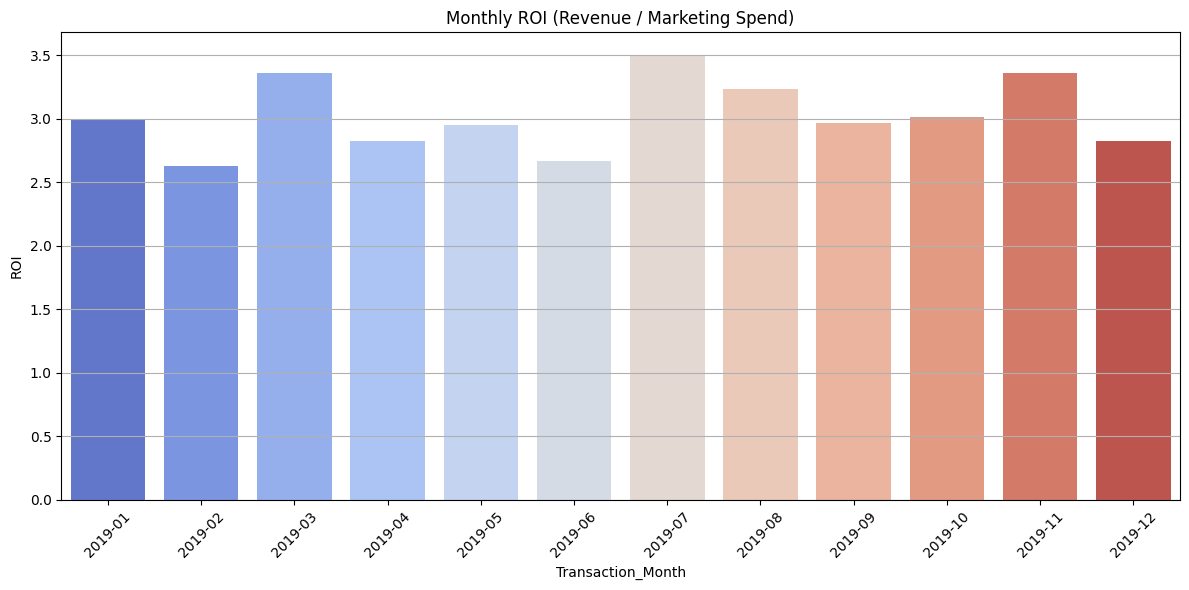

In [ ]:
#Business Question 8 :
#Analyze the relationship between monthly marketing spend and revenue. 
# Are there any months where marketing efforts yielded disproportionately high or low returns?
#  How can marketing strategies be adjusted to improve ROI?

sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])
sales['Revenue'] = (sales['Quantity'] * sales['Avg_Price']) + sales['Delivery_Charges']
sales['Transaction_Month'] = sales['Transaction_Date'].dt.to_period('M').astype(str)

# Aggregate monthly revenue
monthly_revenue = sales.groupby('Transaction_Month')['Revenue'].sum().reset_index()

# Preprocess marketing data
marketing['Date'] = pd.to_datetime(marketing['Date'])
marketing['Month'] = marketing['Date'].dt.to_period('M').astype(str)

# Aggregate monthly marketing spend
monthly_marketing = marketing.groupby('Month')[['Offline_Spend', 'Online_Spend']].sum().reset_index()
monthly_marketing['Total_Spend'] = monthly_marketing['Offline_Spend'] + monthly_marketing['Online_Spend']

# Ensure both are string for merge
combined = pd.merge(monthly_revenue, monthly_marketing, left_on='Transaction_Month', right_on='Month')

# Calculate ROI as Revenue / Total Marketing Spend
combined['ROI'] = combined['Revenue'] / combined['Total_Spend']

# Plot Revenue vs Marketing Spend
plt.figure(figsize=(12, 6))
sns.lineplot(x='Transaction_Month', y='Revenue', data=combined, marker='o', label='Revenue')
sns.lineplot(x='Transaction_Month', y='Total_Spend', data=combined, marker='o', label='Marketing Spend')
plt.title('Monthly Revenue vs Marketing Spend')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
#plt.savefig("images/Q8_MonthlyRevenuevsMarketingSpend.png")
plt.show()

# Plot ROI
plt.figure(figsize=(12, 6))
sns.barplot(x='Transaction_Month', y='ROI', data=combined, palette='coolwarm')
plt.title('Monthly ROI (Revenue / Marketing Spend)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
#plt.savefig("images/Q8_Monthly_ROI.png")
plt.show()